# Voyages API  - Port Congestion

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/VoyagesAPI/Port%20Congestion.ipynb)

## Setup
Install the Signal Ocean SDK:
```
pip install signal-ocean
```
Set your subscription key acquired here: https://apis.signalocean.com/profile

In [1]:
pip install signal-ocean

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\l.argiriou\Miniconda3\envs\minimal_ds\python.exe -m pip install --upgrade pip' command.


In [2]:
signal_ocean_api_key = ""  # replace with your subscription key

## Scope

This example provides information about the following:  
* Live & historical number of vessels waiting/operating at ports/areas of interest.
* Historical waiting time of vessels at ports/areas of interest.

## Methodology

We are going to use voyages that have started over the last 365 days.  

Generally, in order to identify the time intervals that a vessel was waiting/operating during a port call, we have to drill down to event details of its voyage.  
We will built up the methodology used in more details as we go.

## Retrieve data

In [3]:
from signal_ocean import Connection
from signal_ocean.voyages import VoyagesAPI

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
from datetime import date, datetime, timedelta
from functools import reduce
import plotly.express as px
#from plotly.offline import iplot, init_notebook_mode
#init_notebook_mode()

In [4]:
import plotly.io as pio
pio.renderers.default = "png"

Port congestion will be created using the voyages data api.

In [5]:
connection = Connection(signal_ocean_api_key)
api = VoyagesAPI(connection)

In this example, we will retrieve voyages of Capesize vessels that started during the last 365 days.

In [6]:
%%time
capesize_id = 70
date_from = date.today() - timedelta(days = 365)

voyages_flat = api.get_voyages_flat(
    vessel_class_id=capesize_id, date_from=date_from
)

Wall time: 38.5 s


In [7]:
voyages_df = pd.DataFrame(v.__dict__ for v in voyages_flat.voyages)
events_df = pd.DataFrame(v.__dict__ for v in voyages_flat.events)
events_details_df = pd.DataFrame(v.__dict__ for v in voyages_flat.event_details)
geos_df = pd.DataFrame(v.__dict__ for v in voyages_flat.geos).drop_duplicates()

We merge voyages, events and event details in order to capture each detail of each voyage.

In [8]:
left_merge_keys = iter(['id','id_ev'])
right_merge_keys = iter(['voyage_id','event_id'])
suffixes = iter([('_voy','_ev'),('_ev','_det')])

voyages_extd = reduce(
    lambda left,right: pd.merge(
        left,
        right,
        how ='left',
        left_on = next(left_merge_keys,None),
        right_on = next(right_merge_keys,None),
        suffixes = next(suffixes,None)), 
    [voyages_df, events_df, events_details_df]
)

We need only port calls where the vessels executed an operation (Load/Discharge).  
We exlude STS operations since they do not add up to port congestion.

In [9]:
voyages_extd = voyages_extd[
    (voyages_extd['purpose'].isin(['Load', 'Discharge'])) &
    (voyages_extd['event_detail_type'] != 'StS')
]

Port Congestion calculation takes into account also stopped vessels outside the port/anchorage limits using the forecasted part of the voyage (mainly driven from AIS).  
This is achieved by 'connecting' future(predicted) port calls with their previous stops, given that the stops ended during the last 24 hours from the beginnning of the port calls.  
The above results to new extended port calls that span from previous stop arrival date to future portcall sailing date.

In [10]:
future_portcalls = (
    events_df
    .loc[
    (events_df['purpose'].isin(['Load', 'Discharge'])) & 
    (events_df['event_horizon'] == 'Future')
    ]
)

stops = events_df.loc[(events_df['purpose'] == 'Stop')]

future_portcalls_extd = future_portcalls.merge(
    stops, 
    how = 'inner',
    left_on = 'voyage_id', 
    right_on = 'voyage_id', 
    suffixes = ('_fportcalls', '_stops')
)

future_portcalls_extd['stop_portcall_diff'] = (
    (future_portcalls_extd['arrival_date_fportcalls'] - 
     future_portcalls_extd['sailing_date_stops'])
    .dt
    .total_seconds()
)/3600

future_portcalls_extd = (
    future_portcalls_extd
    .loc[future_portcalls_extd['stop_portcall_diff'] <= 24]
)

future_portcalls_extd = (
    future_portcalls_extd
    .sort_values('sailing_date_stops')
    .groupby('voyage_id')
    .tail(1)
)

future_portcalls_extd['original_sailing_date_fportcalls'] = future_portcalls_extd['sailing_date_fportcalls']
print(f'Stops-Future PortCalls Connected: {future_portcalls_extd.shape[0]}')

Stops-Future PortCalls Connected: 73


In the code block below we are merging the oringinal event details(enriched with events and voyage info) with the extended port calls we mentioned above.  
This aims to update the event details attributes for the extended port calls.  
The result of the merge will produce a column named Exist which indicates the following:  
* Exist = 'both': "connected" Stops-Future PortCalls
* Exist = 'left_only': original PortCalls, without connected Stops-Future PortCalls

In [11]:
voyages_final_df = (
    voyages_extd
    .merge(
        future_portcalls_extd, 
        how="outer", 
        left_on=['id_voy', 'id_ev'], 
        right_on=['voyage_id', 'id_fportcalls'], 
        suffixes=('_connected', '_portcalls'), 
        indicator='Exist'
    )
)

## Waiting/Operating Intervals Calculation

In a few words, the date range between start_time_of_operation and end_time_of_operation(sailing date) will be marked as Operating, 
and the rest of the days inside each port call are going to be marked as waiting.  
Later on we will dive into further details.

### Waiting  

We will split the port calls into 4 categories whose waiting interval calculation is differentiated.  
For each category start/end time of the waiting interval is calculated as follows:  
* **Historical Port Calls with start time of operation** : 
    * waiting_time_start -> event arrival date
    * waiting_time_end -> one day prior to the start time of operation
* **Historical Port Calls without start time of operation** :    
(Note) A historical port call may lack the attribute start time of operation due to low ais density during the port call.
    * waiting_time_start -> event arrival date
    * waiting_time_end -> event detail sailing date 
* **Current Port Calls without start time of operation** :    
(Note) A Current port call may also have event_horizon = 'Future' due to missing AIS data.
    * waiting_time_start -> event arrival date
    * waiting_time_end -> event sailing date  
* **Extended Port Calls** :    
(Note) A Current port call may also have event_horizon = 'Future' due to missing AIS data.
    * waiting_time_start -> arrival date of previous stop
    * waiting_time_end -> event sailing date  

In [12]:
hist_port_calls_with_start_time_of_operation = (
    voyages_final_df.start_time_of_operation.notna()
)

hist_port_calls_without_start_time_of_operation = (
    (voyages_final_df.start_time_of_operation.isna()) &
    (voyages_final_df.event_horizon == 'Historical')
)

current_port_calls_without_start_time_of_operation = (
    (voyages_final_df.start_time_of_operation.isna()) &
    (voyages_final_df.event_horizon.isin(['Current', 'Future']))
)

port_calls_merged_with_previous_stops = (
    (voyages_final_df.Exist == 'both')
)

In [13]:
voyages_final_df.loc[
    hist_port_calls_with_start_time_of_operation |
    hist_port_calls_without_start_time_of_operation |
    current_port_calls_without_start_time_of_operation,
    'waiting_time_start'] = (
    voyages_final_df[
    hist_port_calls_with_start_time_of_operation |
    hist_port_calls_without_start_time_of_operation |
    current_port_calls_without_start_time_of_operation 
    ].arrival_date_ev
)

voyages_final_df.loc[
    port_calls_merged_with_previous_stops,
    'waiting_time_start'] = (
    voyages_final_df[port_calls_merged_with_previous_stops]
    .arrival_date_stops
)


voyages_final_df.loc[
    hist_port_calls_with_start_time_of_operation,
    'waiting_time_end'] = (
    voyages_final_df[hist_port_calls_with_start_time_of_operation]
    .start_time_of_operation
    .apply(lambda x:datetime.combine(x, datetime.min.time()) - timedelta(minutes = 1))
)
    
voyages_final_df.loc[
    hist_port_calls_without_start_time_of_operation,
    'waiting_time_end'] = (
    voyages_final_df[hist_port_calls_without_start_time_of_operation]
    .sailing_date_det
)
    
voyages_final_df.loc[
    current_port_calls_without_start_time_of_operation,
    'waiting_time_end'] = (
    voyages_final_df[current_port_calls_without_start_time_of_operation].sailing_date_ev
)

voyages_final_df.loc[
    port_calls_merged_with_previous_stops,
    'waiting_time_end'] = (
    voyages_final_df[port_calls_merged_with_previous_stops]
    .sailing_date_fportcalls
)


### Operating  

The operating time interval is simply calculated by taking as operating_time_start the start time of operation and as operating_time_end the end time of operation.  
In cases that later is not available the event sailing date is used instead.

In [14]:
voyages_final_df.loc[
    hist_port_calls_with_start_time_of_operation,
    'operating_time_start'] = (
    voyages_final_df[
    hist_port_calls_with_start_time_of_operation 
    ].start_time_of_operation
)
    
voyages_final_df.loc[
    hist_port_calls_with_start_time_of_operation &
    (voyages_final_df.end_time_of_operation.notna()),
    'operating_time_end'] = (
    voyages_final_df[
    hist_port_calls_with_start_time_of_operation &
    (voyages_final_df.end_time_of_operation.notna())
    ].end_time_of_operation
)
    
voyages_final_df.loc[
    hist_port_calls_with_start_time_of_operation &
    (voyages_final_df.end_time_of_operation.isna()),
    'operating_time_end'] = (
    voyages_final_df[
    hist_port_calls_with_start_time_of_operation &
    (voyages_final_df.end_time_of_operation.isna())
    ].sailing_date_ev
)

## Calculating the Mode Per Day  

The code below is used to mark each pair of date and imo with the correct Mode(Waiting/Operating).  
We are using the assumption that for each day one vessel can be either waiting or operating and not both. In case of overlapping between waiting and operating interval, the days inside are marked as operating.

In [15]:
voyages_final_df['waiting_duration'] = (
    voyages_final_df
    .apply(lambda row: pd.date_range(
        row.waiting_time_start.date(), 
        row.waiting_time_end.date()),
    axis = 1)
)
    
voyages_final_df['operating_duration'] = (
    voyages_final_df
    .apply(lambda row: pd.date_range(
        row.operating_time_start.date(), 
        row.operating_time_end.date()) if not pd.isnull(row.operating_time_start) else [], 
    axis = 1)
)

In [16]:
vessels_status_df = (
    pd.concat(
    [(voyages_final_df
      .explode('operating_duration')
      .rename({'operating_duration':'DayDate'}, axis='columns')
      .assign(Mode='Operating')),
     (voyages_final_df
      .explode('waiting_duration')
      .rename({'waiting_duration':'DayDate'}, axis='columns')
      .assign(Mode='Waiting'))],
    ignore_index = True
    )
    .drop_duplicates(subset = ['imo','DayDate'], keep = 'first')
)    

Here we are updating the columns affected by the extension of the future/predicted port calls we mentioned earlier.

In [17]:
mapping_dict = {'geo_asset_name':['geo_asset_name_fportcalls','geo_asset_name_ev'],
                'geo_asset_id':['geo_asset_id_fportcalls','geo_asset_id_ev'], 
                'purpose':['purpose_fportcalls','purpose'],
                'latitude':['latitude_fportcalls','latitude_ev'],
                'longitude':['longitude_fportcalls','longitude_ev'],
                'port_name':['port_name_fportcalls','port_name'], 
                'arrival_date':['arrival_date_stops','arrival_date_ev'],
                }

In [18]:
conditions = [(vessels_status_df['Exist'] == 'both'), (vessels_status_df['Exist'] != 'both')]
for key, value in mapping_dict.items():
    actions = [vessels_status_df[value[0]], vessels_status_df[value[1]]]
    vessels_status_df[key] = np.select(conditions, actions, default=actions[0])

In [19]:
#for key, value in mapping_dict.items():
#    vessels_status_df[key] = (
#        vessels_status_df.apply( lambda row:
#        row[value[0]] if row.Exist == 'both'
#        else row[value[1]], 
#        axis = 1)
#    )

In [20]:
vessels_status_df_datetimetz = vessels_status_df.select_dtypes('datetimetz')
vessels_status_df[vessels_status_df_datetimetz.columns] = (
    vessels_status_df_datetimetz
    .apply(lambda x: x.dt.tz_convert(None), 
           axis = 0)
)

In [21]:
vessels_status_df = vessels_status_df[
    vessels_status_df.DayDate.dt.date <= date.today()]

## Business Cases and Plots

### Historical Port Congestion

Historical Port Congestion is translated to the number of vessels waiting or operating Over Time.   
In this particular example we will focus on the historical port congestion across the globe.

In [22]:
num_of_vessels_time_series = vessels_status_df.groupby('DayDate')['imo'].nunique().reset_index()
num_of_vessels_time_series.columns = ['date', 'vessels']
num_of_vessels_time_series

,date,vessels
0,2021-01-23,1
1,2021-01-24,1
2,2021-01-25,2
3,2021-01-26,2
4,2021-01-27,3
...,...,...
355,2022-01-13,482
356,2022-01-14,490
357,2022-01-15,501
358,2022-01-16,514


In [23]:
# Helper 2Function that adds date buttons in time series visualisations
def add_date_buttons(months_back, time_series):
    current_date = datetime.utcnow().date()
    past_date = current_date - pd.DateOffset(months=months_back)
    if (months_back < 12):
        label_m = str(months_back) + 'm'
        if past_date >= time_series.date.min(): date_buttons.append(dict(count = months_back, label = label_m, step = "month", stepmode = "backward"))
    else:
        label_y = str(int(months_back/12)) + 'y'
        if past_date >= time_series.date.min(): date_buttons.append(dict(count = int(months_back/12), label = label_y, step = "year", stepmode = "backward"))
    return date_buttons

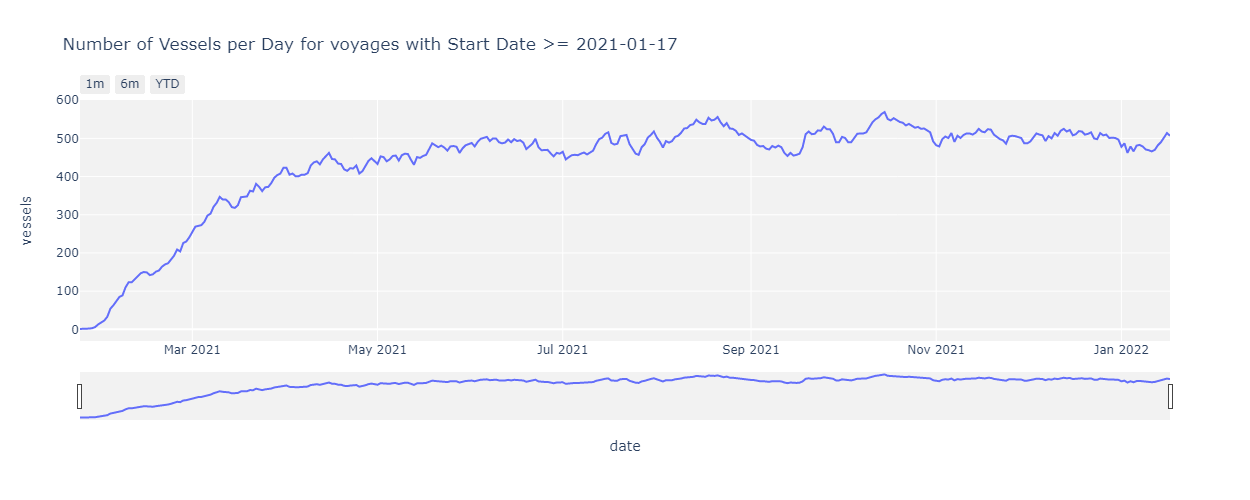

In [24]:
fig = px.line(num_of_vessels_time_series, x='date', y='vessels', 
              title = f'Number of Vessels per Day for voyages with Start Date >= {date_from}')

fig.update_traces(hovertemplate='Date: %{x|%Y-%m-%d}<br>Day: %{x|%A}<br>Vessels: %{y}')

# Add buttons with dates, if applicable
date_buttons = []
date_buttons = add_date_buttons(1, num_of_vessels_time_series) # 1 month back
date_buttons = add_date_buttons(6, num_of_vessels_time_series) # 6 months back
date_buttons = add_date_buttons(12, num_of_vessels_time_series) # 12 months back
date_buttons.append(dict(count = 1, label = "YTD", step = "year", stepmode = "todate"))
fig.update_xaxes(rangeslider_visible = True, rangeselector = dict(buttons = date_buttons))
fig.update_layout(
    width=1250,
    height=500,
    plot_bgcolor = 'rgba(0,0,0,0.05)')
fig.show() 

### Live Port Congestion

Live Port Congestion is translated to the number of vessels currently waiting or operating.  
We also take into account vessels that have finished their current port call today or are expected to start their current port call within the day.

In [25]:
vessel_at_port_df = vessels_status_df[
    (vessels_status_df.DayDate.dt.date == date.today())
].copy()

In [26]:
vessel_at_port_df['days_at_port'] = (
    (vessel_at_port_df.DayDate - vessel_at_port_df['arrival_date'])
    .dt
    .total_seconds()
    /(60*60*24.0)
)

In [27]:
vessel_at_port_df.loc[vessel_at_port_df.days_at_port < 0, 'days_at_port'] = None

In [28]:
vessel_at_port_df = vessel_at_port_df.merge(
    geos_df,
    how = 'inner',
    left_on = 'geo_asset_id',
    right_on = 'id',
    suffixes = ['_at_port','_geos']
)

#### Live Congestion in Ningbo

In [29]:
vessel_at_port_df[vessel_at_port_df.port_name_geos == 'Ningbo']\
[['imo','vessel_name','area_name_level0_geos','country_geos','geo_asset_name','port_name_geos','arrival_date','Mode','days_at_port']]


,imo,vessel_name,area_name_level0_geos,country_geos,geo_asset_name,port_name_geos,arrival_date,Mode,days_at_port
17,9278571,Ocean Queen,Central China,China,Ningbo Iron & Steel,Ningbo,2022-01-11 11:50:56.000,Operating,5.506296
18,9631321,Cape Stars,Central China,China,Ningbo Iron & Steel,Ningbo,2022-01-09 11:58:07.000,Operating,7.501308
186,9604196,Pacific North,Central China,China,Zheneng Liuheng Power Station,Ningbo,2022-01-12 07:46:58.000,Operating,4.675718
224,9747869,True Corsair,Central China,China,Ningbo Bulk Terminal,Ningbo,2022-01-13 03:45:11.000,Operating,3.843623
238,9920679,Ace Eternity,Central China,China,Zhoushan Wugang Dock,Ningbo,2022-01-12 11:49:40.000,Operating,4.507176
343,9344485,Cape Veni,Central China,China,Ningbo,Ningbo,2022-01-15 11:43:05.000,Waiting,1.511748
344,9453731,Berge Torre,Central China,China,Ningbo,Ningbo,2022-01-16 03:47:40.000,Waiting,0.841898
345,9472282,Rutland,Central China,China,Ningbo,Ningbo,2022-01-17 11:23:18.361,Waiting,NaN
346,9567984,Linda Hope,Central China,China,Ningbo,Ningbo,2022-01-16 03:47:59.000,Waiting,0.841678
347,9593309,Cape Asia,Central China,China,Ningbo,Ningbo,2022-01-16 11:38:05.000,Waiting,0.515220


#### Days at port Heatmap (globally)

In this example we are displaying the density of the measure 'days at port' around the world.  
Dasy at port correspond to the difference between current date and port call arrival date.

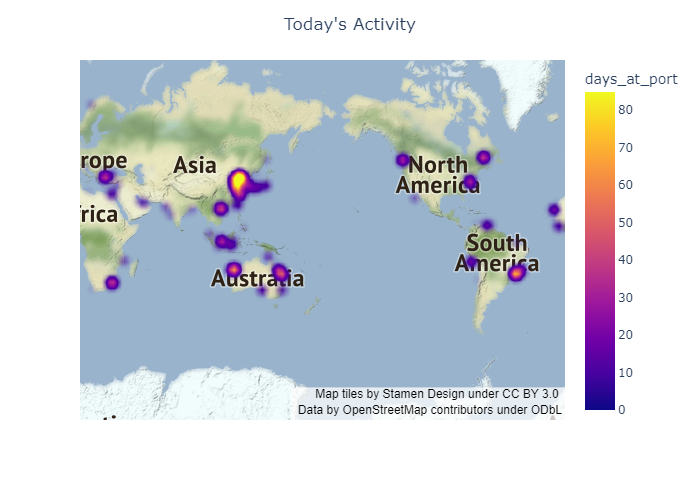

In [30]:
fig = px.density_mapbox(vessel_at_port_df, lat = 'latitude', lon = 'longitude', z = 'days_at_port', radius = 10,
                        center = dict(lat = 0, lon = 180),zoom = 0, mapbox_style = "stamen-terrain",
                        custom_data = ['imo', 'vessel_name', 'purpose', 'port_name_geos', 'arrival_date', 'days_at_port'])
fig.update_layout(
    title = "Today's Activity", 
    title_x = 0.5,
    width=700,
    height=500)
fig.update_traces(hovertemplate = 'IMO: %{customdata[0]} <br>Vessel Name: %{customdata[1]} <br>Purpose: %{customdata[2]} <br>Port: %{customdata[3]} <br>Arrival Date: %{customdata[4]} <br>Days at port: %{customdata[5]:.1f}')
fig.show()

#### Busiest Ports in China

With this example we can monitor the number of vessels and their current Mode under any areas of interest. 

In [31]:
aggregated_df = (
    vessel_at_port_df[
        (vessel_at_port_df.area_name_level0_geos.isin(
            ['Central China','North China', 'South China'])
        )
    ]
    .groupby(['port_name_geos','Mode'])
    .imo
    .nunique()
    .reset_index()
    .rename(columns = {'imo':'num_of_vessels'})
)

In [32]:
top_10_busy_ports = (
    aggregated_df.
    groupby('port_name_geos')
    .num_of_vessels
    .sum()
    .sort_values(ascending = False)
    .head(10)
    .index
)

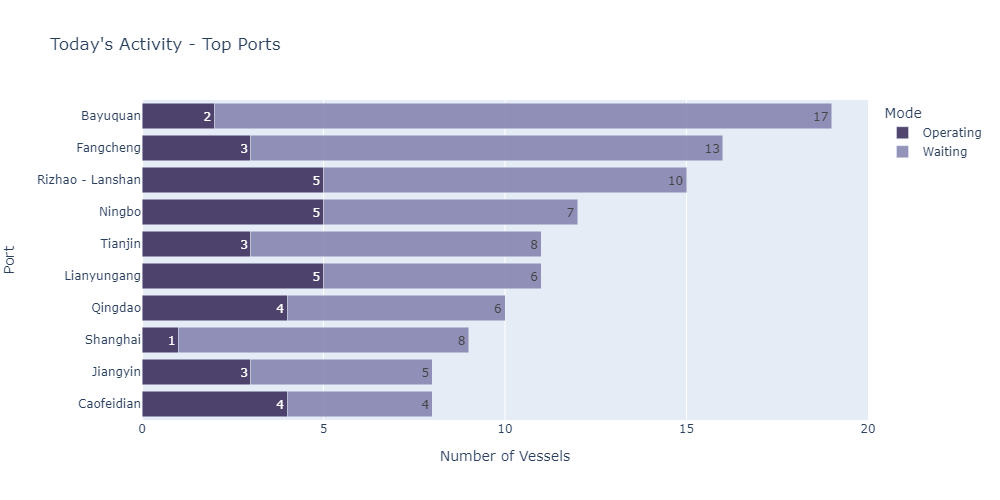

In [33]:
colors = ['rgba(38, 24, 74, 0.8)', 'rgba(122, 120, 168, 0.8)']
fig = px.bar(aggregated_df[aggregated_df.port_name_geos.isin(top_10_busy_ports)], 
             y = 'port_name_geos', 
             x = 'num_of_vessels', 
             color= 'Mode', 
             title="Today's Activity - Top Ports", 
             orientation = 'h', 
             color_discrete_sequence = colors, 
             text = 'num_of_vessels', 
             custom_data = ['Mode'])

fig.update_layout(
    width=1000,
    height=500, 
    xaxis_title= 'Number of Vessels', yaxis_title = 'Port', barmode = 'stack', 
    yaxis = {'categoryorder':'total ascending'}
) 

fig.update_traces(hovertemplate = '%{y} <br>%{customdata[0]}: %{x}<extra></extra>')
fig.show()

### Historical Waiting Time

Waiting Time is calculated for each day of each port call and is defined as the difference between that day and the starting point of the waiting interval.  
We have noticed that the following assumptions lead to more accurate calculations:  
* The first point of each interval is rolled over one day.
* We do not take into account Waiting Time over 60 days (removing outliers).

In [34]:
waiting_vessels = vessels_status_df[
    (vessels_status_df.Mode == 'Waiting') & 
    (vessels_status_df.waiting_time_start.dt.date != vessels_status_df.DayDate.dt.date)
].copy()

In [35]:
waiting_vessels['waiting_time'] = (
    (waiting_vessels['DayDate'] - waiting_vessels['waiting_time_start'])
    .dt.total_seconds()/(60*60*24.0)
)

In [36]:
waiting_time_df = (
    waiting_vessels[
    (waiting_vessels.waiting_time < 60) & 
    (waiting_vessels.DayDate.dt.date != date.today())
    ].groupby('DayDate')['waiting_time']
    .mean()
    .reset_index()
    .rename(columns = {'waiting_time':'avg_waiting_time'})
    .set_index('DayDate')
)

waiting_time_df.avg_waiting_time = waiting_time_df.avg_waiting_time.round(1)

all_days = pd.date_range(waiting_time_df.index.min(), waiting_time_df.index.max(), freq = 'D')
waiting_time_df = waiting_time_df.reindex(all_days)

waiting_time_df['7d MA'] = np.around(
    waiting_time_df
    .avg_waiting_time
    .rolling(window = 7, min_periods = 1).mean(), 
    decimals = 2
)

In [37]:
waiting_time_df.tail(10)

,avg_waiting_time,7d MA
2022-01-07,7.3,7.40
2022-01-08,7.2,7.39
2022-01-09,7.1,7.31
2022-01-10,7.5,7.33
2022-01-11,7.6,7.34
2022-01-12,7.5,7.37
2022-01-13,7.0,7.31
2022-01-14,6.8,7.24
2022-01-15,6.8,7.19
2022-01-16,6.5,7.10


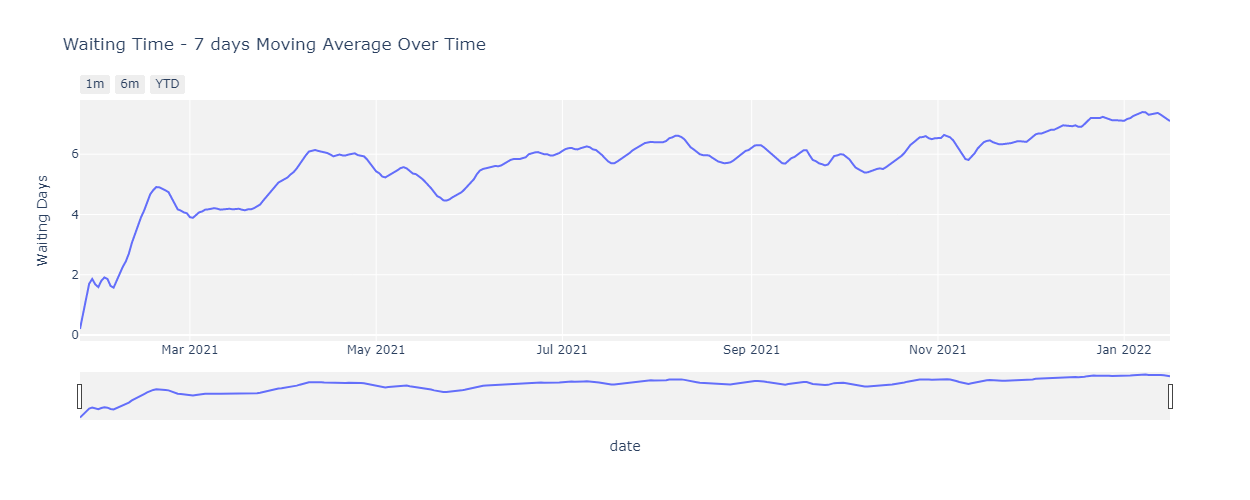

In [38]:
waiting_time_df['date'] = waiting_time_df.index

fig = px.line(waiting_time_df, x = 'date', y = '7d MA', 
              title = f'Waiting Time - 7 days Moving Average Over Time')

fig.update_traces(hovertemplate='Date: %{x|%Y-%m-%d}<br>Day: %{x|%A}<br>7d MA: %{y:.1f}')

# Add buttons with dates, if applicable
date_buttons = []
date_buttons = add_date_buttons(1, waiting_time_df) # 1 month back
date_buttons = add_date_buttons(6, waiting_time_df) # 6 months back
date_buttons = add_date_buttons(12, waiting_time_df) # 12 months back
date_buttons.append(dict(count = 1, label = "YTD", step = "year", stepmode = "todate"))

fig.update_xaxes( rangeslider_visible = True, rangeselector = dict(buttons = date_buttons))
fig.update_yaxes(title_text = 'Waiting Days')
fig.update_layout(
    width=1250,
    height=500,
    plot_bgcolor = 'rgba(0,0,0,0.05)')

fig.show()